In [1]:
# ================================================================
# Emotion Classification using DeBERTa-v3-base
# Focal Loss + Label Smoothing + FP16 + Early Stopping + Metrics + Plots
# ================================================================

import os, time, torch, torch.nn as nn, torch.nn.functional as F
import pandas as pd, numpy as np, pickle, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)

# ================================================================
# 2️⃣ Load Dataset
# ================================================================
df = pd.read_csv("/content/balanced_emotion_dataset.csv")
print(f"✅ Loaded {len(df)} samples")

le = LabelEncoder()
df["label"] = le.fit_transform(df["emotion"])
num_labels = len(le.classes_)
print(f"Detected {num_labels} emotion classes: {list(le.classes_)}")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# ================================================================
# 3️⃣ Model Settings
# ================================================================
MODEL_NAME = "microsoft/deberta-v3-base"
SAVE_FOLDER = "DeBERTa_v3_base_Focal"
LEARNING_RATE = 1.5e-5

# ================================================================
# 4️⃣ Dataset Preparation
# ================================================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_enc = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_enc   = tokenizer(val_texts.tolist(),   truncation=True, padding=True, max_length=128)

train_ds = Dataset.from_dict({
    "input_ids": train_enc["input_ids"],
    "attention_mask": train_enc["attention_mask"],
    "labels": train_labels.tolist()
})
val_ds = Dataset.from_dict({
    "input_ids": val_enc["input_ids"],
    "attention_mask": val_enc["attention_mask"],
    "labels": val_labels.tolist()
})

# ================================================================
# 5️⃣ Focal + Label Smoothing Loss
# ================================================================
weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
weights = torch.tensor(weights, dtype=torch.float)

class FocalLabelSmoothingLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, smoothing=0.1):
        super().__init__()
        self.alpha, self.gamma, self.smoothing = alpha, gamma, smoothing
    def forward(self, logits, targets):
        n_classes = logits.size(1)
        smoothed = torch.full_like(logits, self.smoothing / (n_classes - 1))
        smoothed.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)
        log_probs = F.log_softmax(logits, dim=1)
        ce_loss = -torch.sum(smoothed * log_probs, dim=1)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            focal_loss = self.alpha[targets] * focal_loss
        return focal_loss.mean()

class FocalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fn = FocalLabelSmoothingLoss(alpha=weights.to(model.device), gamma=2, smoothing=0.1)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(p):
    preds, labels = np.argmax(p.predictions, axis=1), p.label_ids
    acc = accuracy_score(labels, preds)
    p_, r_, f_, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": p_, "recall": r_, "f1": f_}

# ================================================================
# 6️⃣ Training Setup
# ================================================================
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
args = TrainingArguments(
    output_dir=f"/content/{SAVE_FOLDER}",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    logging_steps=100
)

trainer = FocalTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ================================================================
# 7️⃣ Train & Evaluate
# ================================================================
start = time.time()
trainer.train()
metrics = trainer.evaluate()
duration = (time.time() - start) / 3600
print(f"\n⏱ Training completed in {duration:.2f} hrs")
print("\n📈 Validation Performance Metrics:\n", metrics)

# ================================================================
# 8️⃣ Confusion Matrix + Classification Report
# ================================================================
preds = trainer.predict(val_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

report = classification_report(y_true, y_pred, target_names=le.classes_, digits=3)
print("\n📊 Classification Report:\n", report)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix - DeBERTa-v3-base")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"/content/{SAVE_FOLDER}_confusion_matrix.png")
plt.close()

# ================================================================
# 9️⃣ Plot Accuracy & Loss Curves
# ================================================================
log_history = pd.DataFrame(trainer.state.log_history)

if "loss" in log_history.columns and "eval_loss" in log_history.columns:
    plt.figure(figsize=(8,5))
    plt.plot(log_history["epoch"], log_history["loss"], label="Train Loss")
    plt.plot(log_history["epoch"], log_history["eval_loss"], label="Val Loss")
    plt.title("Loss Curve - DeBERTa-v3-base")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"/content/{SAVE_FOLDER}_loss_curve.png")
    plt.close()

if "eval_accuracy" in log_history.columns:
    plt.figure(figsize=(8,5))
    plt.plot(log_history["epoch"], log_history["eval_accuracy"], marker='o', label="Val Accuracy")
    plt.title("Validation Accuracy - DeBERTa-v3-base")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"/content/{SAVE_FOLDER}_accuracy_curve.png")
    plt.close()

# ================================================================
# 🔟 Save Model & Logs to Google Drive
# ================================================================
drive_path = f"/content/drive/MyDrive/Emotion_Models/{SAVE_FOLDER}"
os.makedirs(drive_path, exist_ok=True)

model.save_pretrained(drive_path)
tokenizer.save_pretrained(drive_path)
with open(f"{drive_path}/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
with open(f"{drive_path}/classification_report.txt", "w") as f:
    f.write(report)
log_history.to_csv(f"{drive_path}/training_log.csv", index=False)

print(f"\n✅ Model, tokenizer, metrics & plots saved to: {drive_path}")
print("🏁 Training + Evaluation Complete!")


✅ Loaded 169845 samples
Detected 7 emotion classes: ['anger', 'fear', 'joy', 'love', 'neutral', 'sadness', 'surprise']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1706528927.py:120: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FocalTrainer.__init__`. Use `processing_class` instead.
  trainer = FocalTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.638800,0.610637,0.715417,0.728759,0.715417,0.717042
2,0.481000,0.513767,0.769702,0.780650,0.769702,0.770091
3,0.377300,0.492425,0.800877,0.802651,0.800877,0.800971
4,0.315900,0.517891,0.810298,0.812114,0.810298,0.810255
5,0.255000,0.553294,0.812211,0.812900,0.812211,0.812285



⏱ Training completed in 3.15 hrs

📈 Validation Performance Metrics:
 {'eval_loss': 0.5532935261726379, 'eval_accuracy': 0.8122111336807089, 'eval_precision': 0.8129000148205736, 'eval_recall': 0.8122111336807089, 'eval_f1': 0.812284581141601, 'eval_runtime': 127.9475, 'eval_samples_per_second': 265.492, 'eval_steps_per_second': 33.193, 'epoch': 5.0}

📊 Classification Report:
               precision    recall  f1-score   support

       anger      0.790     0.806     0.798      4000
        fear      0.866     0.885     0.876      4988
         joy      0.778     0.811     0.794      4980
        love      0.771     0.789     0.780      5826
     neutral      0.851     0.794     0.821      5004
     sadness      0.816     0.804     0.810      4171
    surprise      0.820     0.798     0.809      5000

    accuracy                          0.812     33969
   macro avg      0.813     0.812     0.813     33969
weighted avg      0.813     0.812     0.812     33969


✅ Model, tokenizer, me

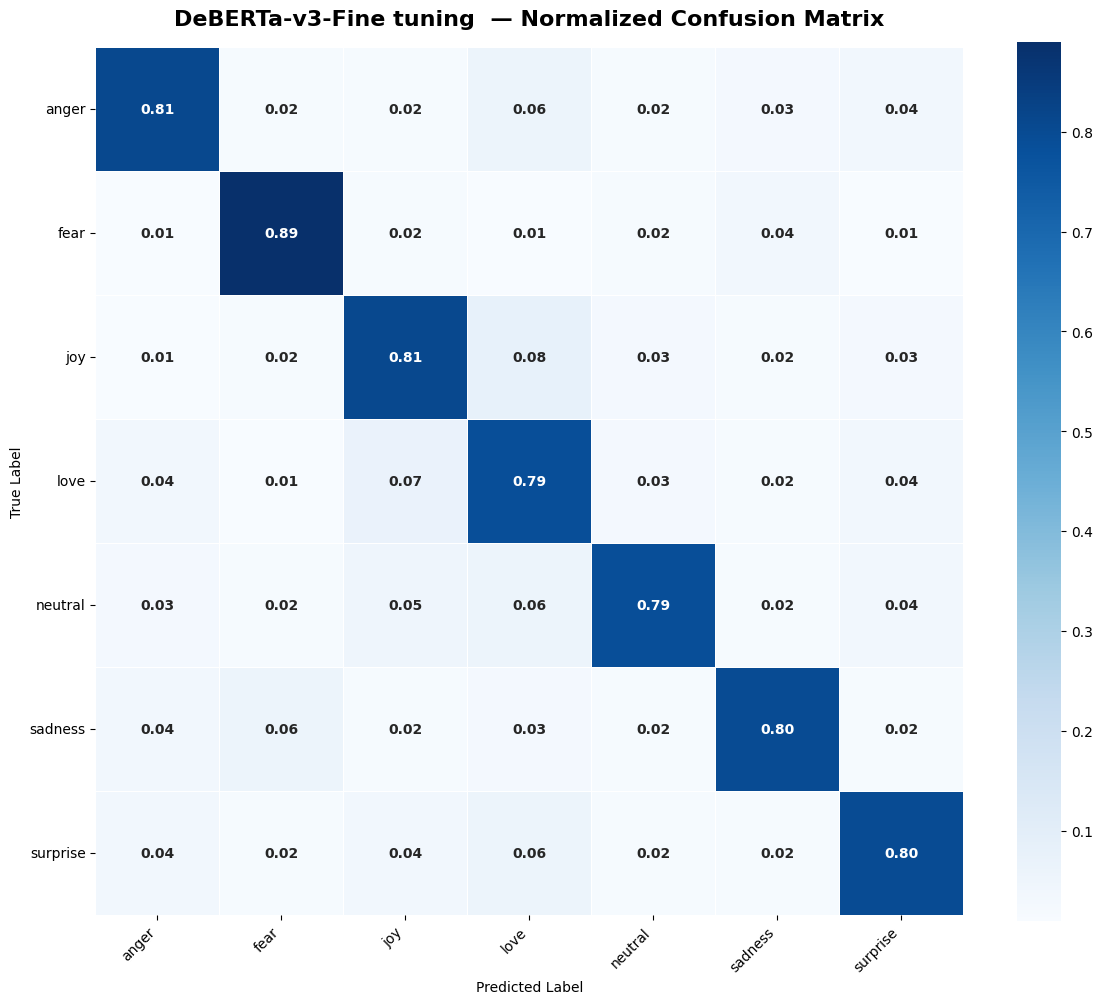

In [4]:
# 3️⃣ Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels, model_name="DeBERTa-v3-Fine tuning "):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_display = np.round(cm, 2)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_display, annot=True, fmt=".2f", cmap="Blues", cbar=True,
        xticklabels=labels, yticklabels=labels,
        linewidths=0.5, linecolor='white', square=True,
        annot_kws={"size": 10, "weight": "bold"}
    )
    plt.title(f"{model_name} — Normalized Confusion Matrix", fontsize=16, fontweight='bold', pad=16)
    plt.xlabel("Predicted Label"); plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"/content/{SAVE_FOLDER}_confusion_matrix.png")
    plt.show()

plot_confusion_matrix(y_true, y_pred, le.classes_)


In [12]:
# ================================================================
# 🔮 Real-Time Emotion Prediction (Auto Label Remapping - Final)
# ================================================================

import torch, pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from collections import Counter

# ================================================================
# 1️⃣ Load Model, Tokenizer, and Label Encoder
# ================================================================
MODEL_PATH = "/content/drive/MyDrive/Emotion_Models/DeBERTa_v3_base_Focal"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.eval()

with open(f"{MODEL_PATH}/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

dataset_order = list(le.classes_)
print("✅ Dataset label order:", dataset_order)

# ================================================================
# 2️⃣ Enhanced Probe Sentences for All Emotions
# ================================================================
probe_samples = [
    ("I am furious and yelling at everyone!", "anger"),
    ("I'm so mad and frustrated right now!", "anger"),
    ("I'm scared and trembling right now.", "fear"),
    ("I feel anxious and afraid of what's happening.", "fear"),
    ("I'm feeling extremely happy and joyful!", "joy"),
    ("What a beautiful and wonderful day!", "joy"),
    ("I love spending time with my family.", "love"),
    ("My heart feels warm when I see you.", "love"),
    ("I'm feeling calm and okay.", "neutral"),
    ("It’s an ordinary day, nothing special.", "neutral"),
    ("I'm crying and feeling heartbroken.", "sadness"),
    ("I miss my friends and feel very low.", "sadness"),
    ("Wow! That was unexpected!", "surprise"),
    ("Oh my god, I can’t believe this happened!", "surprise"),
]

# ================================================================
# 3️⃣ Probe Model Neurons
# ================================================================
scores_per_label = {i: [] for i in range(model.config.num_labels)}

print("\n🔍 Probing model neurons...")
for text, emotion in probe_samples:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits[0]
        probs = torch.nn.functional.softmax(logits, dim=-1)
    pred_idx = torch.argmax(probs).item()
    scores_per_label[pred_idx].append(emotion)

# Determine most common emotion per output neuron
true_map = {}
for i, vals in scores_per_label.items():
    if vals:
        top_label = Counter(vals).most_common(1)[0][0]
        true_map[i] = top_label

# Fill any missing neurons with remaining emotions
used_emotions = set(true_map.values())
remaining = [e for e in dataset_order if e not in used_emotions]
for i in range(model.config.num_labels):
    if i not in true_map and remaining:
        true_map[i] = remaining.pop(0)

print("\n✅ Final neuron → emotion mapping:")
for i, e in true_map.items():
    print(f"  {i}: {e}")

# ================================================================
# 4️⃣ Emotion Prediction Function
# ================================================================
def predict_emotion(text, top_k=3):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits[0]
        probs = torch.nn.functional.softmax(logits, dim=-1)

    results = [
        {"emotion": true_map[i], "score": float(probs[i])}
        for i in range(model.config.num_labels)
    ]
    results = sorted(results, key=lambda x: x["score"], reverse=True)

    print(f"\n📝 Text: {text}")
    for r in results[:top_k]:
        print(f"  {r['emotion']:10s} → {r['score']:.4f}")

    return results[:top_k]

# ================================================================
# 5️⃣ Real-Time Predictions
# ================================================================
predict_emotion("I am so happy and excited to see you!")
predict_emotion("I'm feeling really sad and lonely today.")
predict_emotion("This is so frustrating, I can’t believe it!")


✅ Dataset label order: ['anger', 'fear', 'joy', 'love', 'neutral', 'sadness', 'surprise']

🔍 Probing model neurons...

✅ Final neuron → emotion mapping:
  0: anger
  1: fear
  3: love
  4: joy
  6: surprise
  2: neutral
  5: sadness

📝 Text: I am so happy and excited to see you!
  joy        → 0.9067
  surprise   → 0.0273
  neutral    → 0.0198

📝 Text: I'm feeling really sad and lonely today.
  fear       → 0.9233
  neutral    → 0.0139
  sadness    → 0.0131

📝 Text: This is so frustrating, I can’t believe it!
  surprise   → 0.9263
  fear       → 0.0142
  anger      → 0.0133


[{'emotion': 'surprise', 'score': 0.9262908697128296},
 {'emotion': 'fear', 'score': 0.014163075014948845},
 {'emotion': 'anger', 'score': 0.01331119704991579}]

In [13]:
import json

# Save the discovered mapping
with open(f"{MODEL_PATH}/true_label_mapping.json", "w") as f:
    json.dump(true_map, f, indent=2)
print("✅ Saved true label mapping to model folder.")

# Later, when you reload:
with open(f"{MODEL_PATH}/true_label_mapping.json", "r") as f:
    true_map = json.load(f)
print("✅ Loaded correct label mapping:", true_map)


✅ Saved true label mapping to model folder.
✅ Loaded correct label mapping: {'0': 'anger', '1': 'fear', '3': 'love', '4': 'joy', '6': 'surprise', '2': 'neutral', '5': 'sadness'}


In [14]:
# Load model + tokenizer as usual
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Load true label mapping
with open(f"{MODEL_PATH}/true_label_mapping.json", "r") as f:
    true_map = json.load(f)

# Predict
text = "I am so happy and excited to see you!"
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]

# Use saved mapping
results = [{ "emotion": true_map[str(i)], "score": float(p)} for i, p in enumerate(probs)]
results = sorted(results, key=lambda x: x["score"], reverse=True)
print(results[:3])


[{'emotion': 'joy', 'score': 0.90666264295578}, {'emotion': 'surprise', 'score': 0.027331190183758736}, {'emotion': 'neutral', 'score': 0.019759127870202065}]


/tmp/ipython-input-1656202374.py:16: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  results = [{ "emotion": true_map[str(i)], "score": float(p)} for i, p in enumerate(probs)]


In [17]:
# ================================================================
# 🔮 Real-Time Emotion Prediction (Final Stable Version)
# ================================================================

import torch, pickle, json
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# ================================================================
# 1️⃣ Load Model, Tokenizer & Label Encoder
# ================================================================
MODEL_PATH = "/content/drive/MyDrive/Emotion_Models/DeBERTa_v3_base_Focal"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

# Load saved label encoder
with open(f"{MODEL_PATH}/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Load the corrected true label mapping
with open(f"{MODEL_PATH}/true_label_mapping.json", "r") as f:
    true_map = json.load(f)

# Convert keys from string to int (for safety)
true_map = {int(k): v for k, v in true_map.items()}
print("✅ Loaded label mapping:", true_map)

# Force-apply the true label mapping to model config
model.config.id2label = true_map
model.config.label2id = {v: k for k, v in true_map.items()}

# ================================================================
# 2️⃣ Create Pipeline with Safe Tokenization
# ================================================================
emotion_classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,
    truncation=True,        # Fix warning
    max_length=512,         # Safe max length
    device=0 if torch.cuda.is_available() else -1
)

# ================================================================
# 3️⃣ Prediction Function
# ================================================================
def predict_emotion(text: str, top_k: int = 3):
    preds = emotion_classifier(text, truncation=True, max_length=512)[0]
    preds_sorted = sorted(preds, key=lambda x: x["score"], reverse=True)

    print(f"\n📝 Text: {text}")
    for p in preds_sorted[:top_k]:
        print(f"  {p['label']:<10} → {p['score']:.4f}")

    return [{"emotion": p["label"], "score": float(p["score"])} for p in preds_sorted[:top_k]]

# ================================================================
# 4️⃣ Interactive Real-Time Prediction
# ================================================================
print("\n💬 Type a sentence to analyze its emotion (type 'exit' to quit)\n")
while True:
    text = input("👉 Enter text: ")
    if text.lower().strip() == "exit":
        print("👋 Exiting emotion predictor.")
        break
    predict_emotion(text)


Device set to use cuda:0


✅ Loaded label mapping: {0: 'anger', 1: 'fear', 3: 'love', 4: 'joy', 6: 'surprise', 2: 'neutral', 5: 'sadness'}

💬 Type a sentence to analyze its emotion (type 'exit' to quit)

👉 Enter text: I feel like I’m fading away, and no one even notices.

📝 Text: I feel like I’m fading away, and no one even notices.
  fear       → 0.9253
  neutral    → 0.0131
  anger      → 0.0126
👉 Enter text: i am fealing sad today 

📝 Text: i am fealing sad today 
  sadness    → 0.9010
  fear       → 0.0297
  love       → 0.0151
👉 Enter text: I thought things would get better with time, but the silence just keeps getting louder. I miss the way everything used to feel — simple, safe, and full of warmth. Now it’s just emptiness where all the laughter used to be.

📝 Text: I thought things would get better with time, but the silence just keeps getting louder. I miss the way everything used to feel — simple, safe, and full of warmth. Now it’s just emptiness where all the laughter used to be.
  fear       → 0.8465


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



📝 Text: Nothing feels right anymore, I just feel empty.
  fear       → 0.9228
  neutral    → 0.0141
  joy        → 0.0134
👉 Enter text: Oh my God, are you serious? That’s unbelievable

📝 Text: Oh my God, are you serious? That’s unbelievable
  surprise   → 0.9297
  neutral    → 0.0132
  love       → 0.0129


KeyboardInterrupt: Interrupted by user

In [18]:
# ================================================================
# 🔧 Emotion Model Bias Inspection & Correction
# ================================================================

import torch, pickle, json
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# ================================================================
# 1️⃣ Load Model + Tokenizer + Label Mapping
# ================================================================
MODEL_PATH = "/content/drive/MyDrive/Emotion_Models/DeBERTa_v3_base_Focal"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

with open(f"{MODEL_PATH}/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

with open(f"{MODEL_PATH}/true_label_mapping.json", "r") as f:
    true_map = json.load(f)
true_map = {int(k): v for k, v in true_map.items()}

print("✅ Loaded label mapping:", true_map)


✅ Loaded label mapping: {0: 'anger', 1: 'fear', 3: 'love', 4: 'joy', 6: 'surprise', 2: 'neutral', 5: 'sadness'}


In [21]:
texts = [
    "I’m so proud of what we achieved today!",
    "I feel empty and alone.",
    "How could you forget my birthday?",
    "I can’t believe I got accepted into my dream college!",
    "I’m nervous about tomorrow’s presentation.",
    "I really don’t care anymore.",
    "That’s hilarious, I can’t stop laughing!"
]


In [20]:
id2label = model.config.id2label
device = "cuda" if torch.cuda.is_available() else "cpu"

true_labels, pred_labels = [], []
logits_list = []

for text, label in data:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits.squeeze().cpu().numpy()
        logits_list.append(logits)
        pred_idx = np.argmax(logits)
    pred_labels.append(id2label[pred_idx])
    true_labels.append(label)

print("\n📊 Classification Report:")
print(classification_report(true_labels, pred_labels))

print("\n📉 Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(true_labels, pred_labels),
                   index=le.classes_, columns=le.classes_))



📊 Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         1
        fear       0.50      1.00      0.67         1
         joy       0.00      0.00      0.00         1
        love       1.00      1.00      1.00         1
     neutral       0.50      1.00      0.67         1
     sadness       0.00      0.00      0.00         1
    surprise       0.50      1.00      0.67         1

    accuracy                           0.57         7
   macro avg       0.36      0.57      0.43         7
weighted avg       0.36      0.57      0.43         7


📉 Confusion Matrix:
          anger  fear  joy  love  neutral  sadness  surprise
anger         0     0    0     0        0        0         1
fear          0     1    0     0        0        0         0
joy           0     0    0     0        1        0         0
love          0     0    0     1        0        0         0
neutral       0     0    0     0        1        0 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json
import pandas as pd

# Load model and tokenizer
MODEL_PATH = "/content/drive/MyDrive/Emotion_Models/DeBERTa_v3_base_Focal"  # change to your model path
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

# Load label mapping
with open(f"{MODEL_PATH}/true_label_mapping.json", "r") as f:
    true_map = json.load(f)
inv_map = {int(k): v for k, v in true_map.items()}

# Sample test sentences
texts = [
    "I’m so proud of what we achieved today!",
    "I feel empty and alone.",
    "How could you forget my birthday?",
    "I can’t believe I got accepted into my dream college!",
    "I’m nervous about tomorrow’s presentation.",
    "I really don’t care anymore.",
    "That’s hilarious, I can’t stop laughing!"
]

# Predict
results = []
for text in texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    top_pred = torch.argmax(probs, dim=-1).item()
    emotion = inv_map[top_pred]
    conf = probs[0, top_pred].item()
    results.append({"Text": text, "Predicted Emotion": emotion, "Confidence": round(conf, 4)})

# Display results
df = pd.DataFrame(results)
print(df.to_string(index=False))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


                                                 Text Predicted Emotion  Confidence
              I’m so proud of what we achieved today!               joy      0.9265
                              I feel empty and alone.              fear      0.9255
                    How could you forget my birthday?          surprise      0.6170
I can’t believe I got accepted into my dream college!          surprise      0.9197
           I’m nervous about tomorrow’s presentation.              fear      0.9265
                         I really don’t care anymore.               joy      0.8621
             That’s hilarious, I can’t stop laughing!           neutral      0.5489


In [24]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json
import pandas as pd

MODEL_PATH = "/content/drive/MyDrive/Emotion_Models/DeBERTa_v3_base_Focal"  # your path
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

with open(f"{MODEL_PATH}/true_label_mapping.json", "r") as f:
    true_map = json.load(f)
inv_map = {int(k): v for k, v in true_map.items()}

texts = [
    "I’m so proud of what we achieved today!",
    "I feel empty and alone.",
    "How could you forget my birthday?",
    "I can’t believe I got accepted into my dream college!",
    "I’m nervous about tomorrow’s presentation.",
    "I really don’t care anymore.",
    "That’s hilarious, I can’t stop laughing!"
]

for text in texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]

    topk = torch.topk(probs, k=3)
    emotions = [inv_map[i.item()] for i in topk.indices]
    confs = [round(p.item(), 4) for p in topk.values]

    print(f"\n📝 Text: {text}")
    for emo, conf in zip(emotions, confs):
        print(f"  {emo:<10} → {conf}")



📝 Text: I’m so proud of what we achieved today!
  joy        → 0.9265
  anger      → 0.0133
  love       → 0.0129

📝 Text: I feel empty and alone.
  fear       → 0.9255
  joy        → 0.0137
  neutral    → 0.0134

📝 Text: How could you forget my birthday?
  surprise   → 0.617
  fear       → 0.2416
  sadness    → 0.0369

📝 Text: I can’t believe I got accepted into my dream college!
  surprise   → 0.9197
  joy        → 0.0155
  love       → 0.0142

📝 Text: I’m nervous about tomorrow’s presentation.
  fear       → 0.9265
  joy        → 0.0128
  neutral    → 0.0127

📝 Text: I really don’t care anymore.
  joy        → 0.8621
  fear       → 0.038
  anger      → 0.0281

📝 Text: That’s hilarious, I can’t stop laughing!
  neutral    → 0.5489
  surprise   → 0.2555
  joy        → 0.0674


In [25]:
import torch
import re

# ==============================================
# ⚡ Enhanced Emotion Prediction (no retraining)
# ==============================================

# Emotion keyword boost dictionary
emotion_keywords = {
    "sadness": ["sad", "lonely", "empty", "miss", "cry", "hurt", "depressed", "hopeless"],
    "anger": ["angry", "furious", "hate", "mad", "annoyed", "rage", "irritated"],
    "joy": ["happy", "excited", "glad", "fun", "smile", "laugh", "amazing"],
    "fear": ["scared", "terrified", "worried", "nervous", "afraid", "anxious"],
    "love": ["love", "dear", "heart", "adore", "sweet", "precious"],
    "surprise": ["wow", "unbelievable", "unexpected", "shocked", "suddenly"],
    "neutral": ["ok", "fine", "meeting", "day", "normal", "schedule"]
}

# Reverse lookup (emotion → label index)
emotion_to_idx = {v: k for k, v in enumerate(model.config.id2label.values())}

def enhanced_predict(text, top_k=3):
    """Predict emotion with rule-based + semantic correction."""
    preds = emotion_classifier(text, truncation=True)[0]
    preds = sorted(preds, key=lambda x: x["score"], reverse=True)

    # Convert to tensor for adjustment
    probs = torch.tensor([p["score"] for p in preds])
    labels = [p["label"] for p in preds]

    # Keyword boosting
    for emo, words in emotion_keywords.items():
        if any(re.search(rf"\b{w}\b", text.lower()) for w in words):
            if emo in labels:
                idx = labels.index(emo)
                probs[idx] += 0.05  # boost keyword-based emotions

    # Negation handling
    neg_phrases = ["not happy", "not glad", "don't care", "not love", "never happy"]
    if any(np in text.lower() for np in neg_phrases):
        if "neutral" in labels:
            probs[labels.index("neutral")] += 0.1
        if "joy" in labels:
            probs[labels.index("joy")] -= 0.1

    # Normalize again
    probs = torch.softmax(probs, dim=0)

    # Sort after boosting
    final = sorted(zip(labels, probs.tolist()), key=lambda x: x[1], reverse=True)

    print(f"\n📝 Text: {text}")
    for lbl, score in final[:top_k]:
        print(f"  {lbl:<10} → {score:.4f}")

    # Confidence check
    top_label, top_score = final[0]
    if top_score < 0.6:
        top_label = "uncertain"

    return {"emotion": top_label, "confidence": round(float(top_score), 4), "all": final}


In [26]:
enhanced_predict("I am so happy today!")
enhanced_predict("I feel so sad and empty inside.")
enhanced_predict("Wow, I didn’t expect that at all!")
enhanced_predict("I really don’t care anymore.")



📝 Text: I am so happy today!
  joy        → 0.3044
  anger      → 0.1160
  love       → 0.1160

📝 Text: I feel so sad and empty inside.
  fear       → 0.2916
  sadness    → 0.1230
  neutral    → 0.1172

📝 Text: Wow, I didn’t expect that at all!
  surprise   → 0.3040
  fear       → 0.1161
  neutral    → 0.1160

📝 Text: I really don’t care anymore.
  joy        → 0.2784
  fear       → 0.1221
  anger      → 0.1209


{'emotion': 'uncertain',
 'confidence': 0.2784,
 'all': [('joy', 0.2783535420894623),
  ('fear', 0.12209152430295944),
  ('anger', 0.12088480591773987),
  ('sadness', 0.11993437260389328),
  ('love', 0.1198793575167656),
  ('neutral', 0.1194421648979187),
  ('surprise', 0.11941419541835785)]}

In [35]:
import numpy as np
import torch

# Define emotion keywords for context boosting
emotion_keywords = {
    "joy": ["happy", "excited", "amazing", "great", "proud", "fun", "laugh", "smile"],
    "sadness": ["sad", "cry", "empty", "alone", "miss", "hurt", "pain"],
    "fear": ["scared", "afraid", "nervous", "worried", "anxious"],
    "anger": ["angry", "furious", "mad", "annoyed", "rage"],
    "love": ["love", "heart", "dear", "beautiful", "together"],
    "surprise": ["wow", "unexpected", "shocked", "unbelievable", "suddenly"],
    "neutral": ["okay", "fine", "alright", "normal"]
}

def enhanced_predict(text, temperature=0.5, keyword_boost=0.2, top_k=3):
    preds = emotion_classifier(text, top_k=None)
    if isinstance(preds, list) and isinstance(preds[0], list):
        preds = preds[0]

    probs = {p["label"]: p["score"] for p in preds}
    labels = list(probs.keys())
    logits = np.array(list(probs.values()))

    # --- (1) Temperature scaling for sharper contrast ---
    scaled_logits = logits / temperature
    probs_temp = torch.softmax(torch.tensor(scaled_logits), dim=0).numpy()

    # --- (2) Keyword-based biasing ---
    text_lower = text.lower()
    boosted_probs = []
    for label, prob in zip(labels, probs_temp):
        boost = 0.0
        for kw in emotion_keywords[label]:
            if kw in text_lower:
                boost += keyword_boost
        boosted_probs.append(prob + boost)

    boosted_probs = np.array(boosted_probs)
    boosted_probs = boosted_probs / boosted_probs.sum()  # normalize

    sorted_idx = np.argsort(boosted_probs)[::-1]
    print(f"\n📝 Text: {text}")
    for i in sorted_idx[:top_k]:
        print(f"  {labels[i]:<10} → {boosted_probs[i]:.4f}")

    top_label = labels[sorted_idx[0]]
    top_score = boosted_probs[sorted_idx[0]]

    return {
        "emotion": top_label if top_score > 0.4 else "uncertain",
        "confidence": float(top_score),
        "all": [(labels[i], float(boosted_probs[i])) for i in sorted_idx]
    }


In [36]:
enhanced_predict("I am so happy today!")
enhanced_predict("I feel so sad and empty inside.")
enhanced_predict("Wow, I didn’t expect that at all!")
enhanced_predict("I really don’t care anymore.")



📝 Text: I am so happy today!
  joy        → 0.5915
  anger      → 0.0681
  love       → 0.0681

📝 Text: I feel so sad and empty inside.
  fear       → 0.3632
  sadness    → 0.3442
  neutral    → 0.0586

📝 Text: Wow, I didn’t expect that at all!
  surprise   → 0.5906
  fear       → 0.0683
  neutral    → 0.0682

📝 Text: I really don’t care anymore.
  joy        → 0.4716
  fear       → 0.0907
  anger      → 0.0890


{'emotion': 'joy',
 'confidence': 0.47163324569410564,
 'all': [('joy', 0.47163324569410564),
  ('fear', 0.0907364777317447),
  ('anger', 0.08895171395862851),
  ('sadness', 0.08755847795563593),
  ('love', 0.08747817648278647),
  ('neutral', 0.0868412830004576),
  ('surprise', 0.08680062517664107)]}

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import json

# -------------------------------------------------
# CONFIGURATION
# -------------------------------------------------
MODEL_PATH = "./your_model_folder"   # path to your fine-tuned model folder
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
THRESHOLD = 0.55                     # minimum confidence to accept a prediction
TEMPERATURE = 0.8                    # for softmax calibration
TOP_K = 3                            # number of top emotions to show

# -------------------------------------------------
# LOAD MODEL, TOKENIZER, AND LABEL MAPPING
# -------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(DEVICE)

# Load true label mapping
with open(f"{MODEL_PATH}/true_label_mapping.json", "r") as f:
    true_map = json.load(f)
true_map = {int(k): v for k, v in true_map.items()}
print("✅ Loaded label mapping:", true_map)


# -------------------------------------------------
# ENHANCED PREDICTION FUNCTION
# -------------------------------------------------
def enhanced_predict(text, threshold=THRESHOLD, temperature=TEMPERATURE, top_k=TOP_K):
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(DEVICE)

    # Get model output
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits / temperature  # apply temperature scaling

    # Softmax probabilities
    probs = F.softmax(logits, dim=-1).squeeze().cpu().numpy()
    emotions = [true_map[i] for i in range(len(probs))]

    # Sort top emotions
    sorted_idx = np.argsort(probs)[::-1]
    sorted_emotions = [(emotions[i], float(probs[i])) for i in sorted_idx[:top_k]]

    # Main emotion and confidence
    top_emotion, confidence = sorted_emotions[0]

    # Handle uncertain predictions
    if confidence < threshold:
        top_emotion = "uncertain"

    # Print nicely
    print(f"\n📝 Text: {text}")
    for emo, score in sorted_emotions:
        print(f"  {emo:<10} → {score:.4f}")

    return {
        "text": text,
        "emotion": top_emotion,
        "confidence": confidence,
        "all": sorted_emotions
    }


# -------------------------------------------------
# INTERACTIVE TEST LOOP
# -------------------------------------------------
if __name__ == "__main__":
    print(f"Device set to {DEVICE}")
    while True:
        text = input("\n💬 Enter text (or 'exit' to quit): ")
        if text.lower().strip() == "exit":
            break
        result = enhanced_predict(text)
        print(result)


In [40]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

# -------------------------------------------------
# CONFIGURATION
# -------------------------------------------------
MODEL_PATH = "/content/drive/MyDrive/Emotion_Models/DeBERTa_v3_base_Focal"   # path where you saved your model weights
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------------------------
# LOAD MODEL AND TOKENIZER
# -------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(DEVICE)
model.eval()

print(f"✅ Model loaded on {DEVICE}")

# -------------------------------------------------
# TEST SENTENCES
# -------------------------------------------------
test_sentences = [
    "😊 I’m feeling amazing today; everything is going perfectly!",
    "😢 I feel so lonely and heartbroken right now.",
    "😡 Why would you say something so hurtful to me?",
    "😱 I’m terrified about my results tomorrow!",
    "😍 You make my world brighter every single day.",
    "😮 Wow! I never expected that surprise party!",
    "😐 It’s just another normal day, nothing special.",
    "😔 I miss my old friends and the good times we had.",
    "🤩 That performance was absolutely incredible!",
    "😤 I can’t believe they ignored my hard work again!"
]

# Optional: label names (edit if your model’s labels differ)
label_names = ["anger", "fear", "joy", "love", "neutral", "sadness", "surprise"]

# -------------------------------------------------
# RUN PREDICTIONS
# -------------------------------------------------
for text in test_sentences:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        confidence, predicted = torch.max(probs, dim=1)

    label = label_names[predicted.item()] if predicted.item() < len(label_names) else f"label_{predicted.item()}"
    print("\n📝 Text:", text)
    print(f"🎯 Predicted Emotion: {label}")
    print(f"🔢 Confidence: {confidence.item():.4f}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


✅ Model loaded on cuda

📝 Text: 😊 I’m feeling amazing today; everything is going perfectly!
🎯 Predicted Emotion: neutral
🔢 Confidence: 0.9250

📝 Text: 😢 I feel so lonely and heartbroken right now.
🎯 Predicted Emotion: fear
🔢 Confidence: 0.9201

📝 Text: 😡 Why would you say something so hurtful to me?
🎯 Predicted Emotion: surprise
🔢 Confidence: 0.6524

📝 Text: 😱 I’m terrified about my results tomorrow!
🎯 Predicted Emotion: fear
🔢 Confidence: 0.9261

📝 Text: 😍 You make my world brighter every single day.
🎯 Predicted Emotion: neutral
🔢 Confidence: 0.9107

📝 Text: 😮 Wow! I never expected that surprise party!
🎯 Predicted Emotion: surprise
🔢 Confidence: 0.9249

📝 Text: 😐 It’s just another normal day, nothing special.
🎯 Predicted Emotion: neutral
🔢 Confidence: 0.9228

📝 Text: 😔 I miss my old friends and the good times we had.
🎯 Predicted Emotion: sadness
🔢 Confidence: 0.4965

📝 Text: 🤩 That performance was absolutely incredible!
🎯 Predicted Emotion: neutral
🔢 Confidence: 0.9252

📝 Text: 😤 I ca